## Load documents with IDs

In [1]:
import json
from tqdm.auto import tqdm


with open('/app/Law_corpus/documents-with-ids.json', 'rt') as f_in:
    documents = json.load(f_in)

In [2]:
documents[150]

{'law_title': 'Luật Hôn Nhân Và Gia Đình',
 'law_number': 'Số: 52/2014/QH13',
 'chapter_title': 'Chương III',
 'article_number': 'Điều 46',
 'title': 'Nhập tài sản riêng của vợ, chồng vào tài sản chung',
 'content': '1. Việc nhập tài sản riêng của vợ, chồng vào tài sản chung được thực hiện theo thỏa thuận của vợ chồng. 2. Tài sản được nhập vào tài sản chung mà theo quy định của pháp luật, giao dịch liên quan đến tài sản đó phải tuân theo hình thức nhất định thì thỏa thuận phải bảo đảm hình thức đó. 3. Nghĩa vụ liên quan đến tài sản riêng đã nhập vào tài sản chung được thực hiện bằng tài sản chung, trừ trường hợp vợ chồng có thỏa thuận khác hoặc pháp luật có quy định khác. ',
 'id': '146451b7'}

## Load ground truth

In [3]:
import pandas as pd

df_ground_truth = pd.read_csv('./evaluate/ground-truth-data.csv')
ground_truth = df_ground_truth.to_dict(orient='records')

In [4]:
ground_truth[0]

{'generated_question': 'Các loại hình cơ sở giáo dục mầm non được quy định như thế nào trong Luật Giáo Dục?',
 'generated_answer': 'Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo độc lập nhận trẻ em từ 03 tuổi đến 06 tuổi; 3. Trường mầm non, lớp mầm non độc lập là cơ sở giáo dục kết hợp nhà trẻ và mẫu giáo, nhận trẻ em từ 03 tháng tuổi đến 06 tuổi.',
 'doc_id': 'a0fcdc5b',
 'law_title': 'Luật Giáo Dục'}

In [5]:
doc_idx = {d['id']: d for d in documents}
doc_idx['a0fcdc5b']

{'law_title': 'Luật Giáo Dục',
 'law_number': 'Luật số: 43/2019/QH14',
 'chapter_title': 'Chương II',
 'article_number': 'Điều 26',
 'title': 'Cơ sở giáo dục mầm non',
 'content': 'Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo độc lập nhận trẻ em từ 03 tuổi đến 06 tuổi; 3. Trường mầm non, lớp mầm non độc lập là cơ sở giáo dục kết hợp nhà trẻ và mẫu giáo, nhận trẻ em từ 03 tháng tuổi đến 06 tuổi. ',
 'id': 'a0fcdc5b'}

In [6]:
ground_truth[0]

{'generated_question': 'Các loại hình cơ sở giáo dục mầm non được quy định như thế nào trong Luật Giáo Dục?',
 'generated_answer': 'Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo độc lập nhận trẻ em từ 03 tuổi đến 06 tuổi; 3. Trường mầm non, lớp mầm non độc lập là cơ sở giáo dục kết hợp nhà trẻ và mẫu giáo, nhận trẻ em từ 03 tháng tuổi đến 06 tuổi.',
 'doc_id': 'a0fcdc5b',
 'law_title': 'Luật Giáo Dục'}

## Index data

In [7]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("truro7/vn-law-embedding", truncate_dim = 768) #truncate_dim = 768

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.07k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

Invalid model-index. Not loading eval results into CardData.


1_Pooling%2Fconfig.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Invalid model-index. Not loading eval results into CardData.


In [8]:
from elasticsearch import Elasticsearch
# es_client = Elasticsearch('http://localhost:9200') 
es_client = Elasticsearch('http://elasticsearch_compose:9200') #connect to docker compose network if runinng from dockerfile container 
# es_client.info()

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "law_title": {"type": "keyword"},                
            "law_number": {"type": "keyword"},               
            "chapter_title": {"type": "keyword"},            
            "article_number": {"type": "keyword"},            
            "title": {"type": "text"},                        
            "content": {"type": "text"},   
            "id": {"type": "text"},   
            "title_content_vector": {                                 
                "type": "dense_vector",
                "dims": 768,                                 
                "index": True,
                "similarity": "cosine"
            }                
        }
    }
}

index_name = "legal_documents_ids"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'legal_documents_ids'})

In [9]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    title = doc['title']
    content = doc['content']
    doc['title_content_vector'] = model.encode(title + ' ' + content)

    es_client.index(index=index_name, document=doc)

  0%|          | 0/314 [00:00<?, ?it/s]

In [10]:
documents[0]

{'law_title': 'Luật Giáo Dục',
 'law_number': 'Luật số: 43/2019/QH14',
 'chapter_title': 'Chương I',
 'article_number': 'Điều 1',
 'title': 'Phạm vi điều chỉnh',
 'content': 'Luật này quy định về hệ thống giáo dục quốc dân; cơ sở giáo dục, nhà giáo, người học; quản lý nhà nước về giáo dục; quyền và trách nhiệm của cơ quan, tổ chức, cá nhân liên quan đến hoạt động giáo dục. ',
 'id': '75a9286e',
 'title_content_vector': array([-1.97882224e-02, -1.99339297e-02,  4.56860475e-02,  8.96888971e-02,
        -5.92795312e-02, -6.35427088e-02,  4.05403003e-02,  1.20414663e-02,
         1.30230516e-01,  3.74822877e-02,  7.43912440e-03,  8.62386171e-03,
         4.33983728e-02,  2.53979526e-02,  1.36169503e-02, -1.71789490e-02,
         6.61228448e-02,  7.36672133e-02, -5.86116761e-02,  9.18327495e-02,
        -1.52075256e-03,  4.18600067e-02,  3.99471521e-02,  8.13104771e-03,
         2.45093219e-02,  8.91548989e-05,  2.86348090e-02, -6.75837044e-03,
         1.57178324e-02,  5.52585609e-02,  1.1

## Retrieval

In [11]:
def elastic_search_knn(field, vector, law_title):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 3,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "law_title": law_title
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["law_title", "law_number", "chapter_title", "article_number", "title", "content","id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def title_content_vector_knn(q):
    questions = q['generated_question']
    law_title = q['law_title']

    v_q = model.encode(questions)

    return elastic_search_knn('title_content_vector', v_q, law_title)


## Add better search method

In [12]:
def bm25_search(q):
    # Extract the question and law title from the input
    question = q['generated_question']
    law_title = q['law_title']
    
    # Construct the BM25 search query
    search_query = {
        "query": {
            "bool": {
                "must": {
                    "multi_match": {
                        "query": question,  # Search for the question in the title and content fields
                        "fields": ["title", "content"]
                    }
                },
                "filter": {
                    "term": {
                        "law_title": law_title  # Filter by the law title
                    }
                }
            }
        },
        "_source": ["law_title", "law_number", "chapter_title", "article_number", "title", "content", "id"],  # Fields to return
        "size": 3  # Number of results to return (adjust as needed)
    }
    
    # Execute the search query
    es_results = es_client.search(index=index_name, body=search_query)
    
    # Extract and return the documents
    return [hit['_source'] for hit in es_results['hits']['hits']]
def hybrid_search(q):
    # Extract the question and law title from the input
    question = q['generated_question']
    law_title = q['law_title']
    
    # Get vector embedding for the question
    question_vector = model.encode(question)
    
    # KNN vector search
    knn_query = {
        "knn": {
            "field": "title_content_vector",
            "query_vector": question_vector.tolist(),
            "k": 3,
            "num_candidates": 10000,
            "filter": {
                "term": {
                    "law_title": law_title
                }
            }
        },
        "query": {
            "bool": {
                "must": {
                    "multi_match": {
                        "query": question,
                        "fields": ["title", "content"],
                        "boost": 0.5  # Give less weight to text matching
                    }
                },
                "filter": {
                    "term": {
                        "law_title": law_title
                    }
                }
            }
        },
        "_source": ["law_title", "law_number", "chapter_title", "article_number", "title", "content", "id"],
        "size": 1
    }
    
    # Execute the hybrid search query
    hybrid_results = es_client.search(
        index=index_name,
        body=knn_query
    )
    
    # Extract and return the documents
    return [hit['_source'] for hit in hybrid_results['hits']['hits']]

In [13]:
title_content_vector_knn(ground_truth[0])

[{'article_number': 'Điều 26',
  'law_number': 'Luật số: 43/2019/QH14',
  'chapter_title': 'Chương II',
  'id': 'a0fcdc5b',
  'title': 'Cơ sở giáo dục mầm non',
  'law_title': 'Luật Giáo Dục',
  'content': 'Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo độc lập nhận trẻ em từ 03 tuổi đến 06 tuổi; 3. Trường mầm non, lớp mầm non độc lập là cơ sở giáo dục kết hợp nhà trẻ và mẫu giáo, nhận trẻ em từ 03 tháng tuổi đến 06 tuổi. '},
 {'article_number': 'Điều 47',
  'law_number': 'Luật số: 43/2019/QH14',
  'chapter_title': 'Chương III',
  'id': 'ff030746',
  'title': 'Loại hình nhà trường trong hệ thống giáo dục quốc dân',
  'law_title': 'Luật Giáo Dục',
  'content': '1. Nhà trường trong hệ thống giáo dục quốc dân được tổ chức theo các loại hình sau đây: a) Trường công lập do Nhà nước đầu tư, bảo đảm điều kiện hoạt động và đại diện chủ sở hữu; b) Trường dân lập do cộng đồng dân cư ở cơ sở gồm tổ chức và cá

In [14]:
bm25_search(ground_truth[0])

[{'article_number': 'Điều 66',
  'law_number': 'Luật số: 43/2019/QH14',
  'chapter_title': 'Chương IV',
  'id': '074a5ce5',
  'title': 'Vị trí, vai trò của nhà giáo',
  'law_title': 'Luật Giáo Dục',
  'content': '1. Nhà giáo làm nhiệm vụ giảng dạy, giáo dục trong cơ sở giáo dục, trừ cơ sở giáo dục quy định tại điểm c khoản 1 Điều 65 của Luật này. Nhà giáo giảng dạy ở cơ sở giáo dục mầm non, giáo dục phổ thông, cơ sở giáo dục khác, giảng dạy trình độ sơ cấp, trung cấp gọi là giáo viên; nhà giáo giảng dạy từ trình độ cao đẳng trở lên gọi là giảng viên. 2. Nhà giáo có vai trò quyết định trong việc bảo đảm chất lượng giáo dục, có vị thế quan trọng trong xã hội, được xã hội tôn vinh. '},
 {'article_number': 'Điều 25',
  'law_number': 'Luật số: 43/2019/QH14',
  'chapter_title': 'Chương II',
  'id': '7bbe02ec',
  'title': 'Chương trình giáo dục mầm non',
  'law_title': 'Luật Giáo Dục',
  'content': '1. Chương trình giáo dục mầm non phải bảo đảm các yêu cầu sau đây: a) Thể hiện mục tiêu giáo d

In [15]:
hybrid_search(ground_truth[0])

[{'article_number': 'Điều 66',
  'law_number': 'Luật số: 43/2019/QH14',
  'chapter_title': 'Chương IV',
  'id': '074a5ce5',
  'title': 'Vị trí, vai trò của nhà giáo',
  'law_title': 'Luật Giáo Dục',
  'content': '1. Nhà giáo làm nhiệm vụ giảng dạy, giáo dục trong cơ sở giáo dục, trừ cơ sở giáo dục quy định tại điểm c khoản 1 Điều 65 của Luật này. Nhà giáo giảng dạy ở cơ sở giáo dục mầm non, giáo dục phổ thông, cơ sở giáo dục khác, giảng dạy trình độ sơ cấp, trung cấp gọi là giáo viên; nhà giáo giảng dạy từ trình độ cao đẳng trở lên gọi là giảng viên. 2. Nhà giáo có vai trò quyết định trong việc bảo đảm chất lượng giáo dục, có vị thế quan trọng trong xã hội, được xã hội tôn vinh. '}]

In [116]:
ground_truth[0]

{'generated_question': 'Các loại hình cơ sở giáo dục mầm non được quy định như thế nào trong Luật Giáo Dục?',
 'generated_answer': 'Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo độc lập nhận trẻ em từ 03 tuổi đến 06 tuổi; 3. Trường mầm non, lớp mầm non độc lập là cơ sở giáo dục kết hợp nhà trẻ và mẫu giáo, nhận trẻ em từ 03 tháng tuổi đến 06 tuổi.',
 'doc_id': 'a0fcdc5b',
 'law_title': 'Luật Giáo Dục'}

## The RAG flow

In [16]:
ground_truth[0]['generated_question']

'Các loại hình cơ sở giáo dục mầm non được quy định như thế nào trong Luật Giáo Dục?'

# Translation layer

# Googletrans

In [18]:
import re
import time
from googletrans import Translator, LANGUAGES
from retry import retry

# Create translator with increased timeout and retries
translator = Translator(service_urls=['translate.google.com'])

# Retry decorator for translation functions
@retry(tries=3, delay=1, backoff=2)
def safe_translate(text, src, dest):
    """
    Performs translation with retry mechanism and proper error handling.
    """
    if not text or text.strip() == "":
        return ""
        
    try:
        # Add a small delay to avoid rate limiting
        time.sleep(0.5)
        translation = translator.translate(text, src=src, dest=dest)
        if translation and hasattr(translation, 'text'):
            return translation.text
        else:
            raise ValueError("Empty translation result")
    except Exception as e:
        print(f"Translation error: {e}")
        # Fallback - return original text if translation fails
        return text

def clean_text(text):
    """
    Cleans text by removing non-printable characters, normalizing whitespace,
    and specifically handling problematic semicolons.
    """
    if not text:
        return ""
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with single spaces
    text = ''.join(c for c in text if c.isprintable())  # Remove non-printable characters
    text = text.replace(';', ',')  # Replace semicolons with commas
    return text.strip()

def undo_clean_text(text):
    """
    Reverses the semicolon replacement done by clean_text.
    """
    if not text:
        return ""
    text = text.replace(',', ';')  # Replace commas back to semicolons
    return text

def translate_in_chunks(text, src='vi', dest='it', chunk_size=1000):
    """
    Translates text in smaller chunks to avoid potential issues with large text.
    """
    if not text:
        return ""
        
    if len(text) <= chunk_size:
        return safe_translate(text, src=src, dest=dest)

    chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]
    translated_chunks = []
    
    for chunk in chunks:
        translated_chunk = safe_translate(chunk, src=src, dest=dest)
        translated_chunks.append(translated_chunk)
        # Add delay between chunk translations
        time.sleep(0.7)
        
    return " ".join(translated_chunks)

def vietnamese_to_italian(text):
    """
    Translates Vietnamese text to Italian with error handling.
    """
    if not text:
        return ""
    return translate_in_chunks(text, src='vi', dest='it')

def italian_to_vietnamese(text):
    """
    Translates Italian text to Vietnamese with error handling.
    """
    if not text:
        return ""
    return translate_in_chunks(text, src='it', dest='vi')


# Deep translator

In [21]:
import re
import time
from deep_translator import GoogleTranslator
from retry import retry

# Retry decorator for translation functions
@retry(tries=3, delay=1, backoff=2)
def safe_translate(text, src, dest):
    """
    Performs translation with retry mechanism and proper error handling.
    """
    if not text or text.strip() == "":
        return ""
        
    try:
        # Add a small delay to avoid rate limiting
        time.sleep(0.5)
        translation = GoogleTranslator(source=src, target=dest).translate(text)
        return translation
    except Exception as e:
        print(f"Translation error: {e}")
        # Fallback - return original text if translation fails
        return text

def clean_text(text):
    """
    Cleans text by removing non-printable characters, normalizing whitespace,
    and specifically handling problematic semicolons.
    """
    if not text:
        return ""
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with single spaces
    text = ''.join(c for c in text if c.isprintable())  # Remove non-printable characters
    text = text.replace(';', ',')  # Replace semicolons with commas
    return text.strip()

def undo_clean_text(text):
    """
    Reverses the semicolon replacement done by clean_text.
    """
    if not text:
        return ""
    text = text.replace(',', ';')  # Replace commas back to semicolons
    return text

def translate_in_chunks(text, src='vi', dest='it', chunk_size=1000):
    """
    Translates text in smaller chunks to avoid potential issues with large text.
    """
    if not text:
        return ""
        
    if len(text) <= chunk_size:
        return safe_translate(text, src=src, dest=dest)

    chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]
    translated_chunks = []
    
    for chunk in chunks:
        translated_chunk = safe_translate(chunk, src=src, dest=dest)
        translated_chunks.append(translated_chunk)
        # Add delay between chunk translations
        time.sleep(0.7)
        
    return " ".join(translated_chunks)

def vietnamese_to_italian(text):
    """
    Translates Vietnamese text to Italian with error handling.
    """
    if not text:
        return ""
    return translate_in_chunks(text, src='vi', dest='it')

def italian_to_vietnamese(text):
    """
    Translates Italian text to Vietnamese with error handling.
    """
    if not text:
        return ""
    return translate_in_chunks(text, src='it', dest='vi')

def vietnamese_to_english(text):
    """
    Translates Vietnamese text to English with error handling.
    """
    if not text:
        return ""
    return translate_in_chunks(text, src='vi', dest='en')

def english_to_vietnamese(text):
    """
    Translates English text to Vietnamese with error handling.
    """
    if not text:
        return ""
    return translate_in_chunks(text, src='en', dest='vi')

In [22]:
def build_prompt(query, search_results, model_type="mamba"):
    """
    Builds a simple prompt by combining the translated query and search results.
    
    Args:
        query (str): The query to be translated and used in the prompt.
        search_results (list): List of search results (documents) to build the context.
        model_type (str): The type of model being used ("mamba" or "transformer").
    
    Returns:
        str: The constructed prompt.
    """
    # Translate the query based on the model type
    if model_type.lower() == "mamba":
        translated_query = vietnamese_to_italian(query)  # Mamba: Vietnamese -> Italian
    else:
        translated_query = vietnamese_to_english(query)  # Transformer: Vietnamese -> English

    # Translate the search results
    translated_docs = []
    for doc in search_results:
        if model_type.lower() == "mamba":
            translated_content = vietnamese_to_italian(doc['content'])  # Translate to Italian
        else:
            translated_content = vietnamese_to_english(doc['content'])  # Translate to English
        translated_docs.append(translated_content)

    # Combine the translated query and documents into a prompt
    prompt = f"Query: {translated_query}\n\nContext:\n"
    for i, doc in enumerate(translated_docs):
        prompt += f"Document {i+1}:\n{doc}\n\n"
    
    return prompt

In [23]:
vietnamese_to_italian("con mèo siêu mập")
print(italian_to_vietnamese('Gatto super grasso'))

Mèo siêu béo


In [49]:
print(vietnamese_to_english("con mèo siêu mập")) 
print(english_to_vietnamese('super fat cat'))

Super fat cat
Mèo siêu béo


In [25]:
query = ground_truth[0]['generated_question']

# Call build_prompt with the extracted question
context = build_prompt(query, title_content_vector_knn(ground_truth[0]))

# Translate the context back to Vietnamese (if needed)
print(italian_to_vietnamese(context))

Truy vấn: Các loại tổ chức mầm non được quy định trong luật giáo dục là gì?

Bối cảnh:
Tài liệu 1:
Các tổ chức giáo dục mầm non bao gồm: 1. Mẫu giáo, một nhóm trẻ em độc lập từ 03 đến 03 tuổi; 2. Các trường mẫu giáo và mẫu giáo độc lập nhận được trẻ em từ 03 đến 06 năm; 3. Năm học mẫu giáo, các bài học trường mẫu giáo độc lập là các tổ chức giáo dục kết hợp mẫu giáo và mẫu giáo, đưa trẻ em từ 03 tháng đến 06 tuổi.

Tài liệu 2:
1 b) Trường tư thục được tổ chức bởi các cộng đồng cơ bản, bao gồm các tổ chức và cá nhân trong làng, ấp, làng, công ty, khớp, đô thị, phòng ban và thành phố để xây dựng cấu trúc vật chất và đảm bảo điều kiện hoạt động. Loại trường tư chỉ áp dụng cho các tổ chức của giáo dục mầm non; c) Các trường tư thục đầu tư bởi các nhà đầu tư quốc gia hoặc các nhà đầu tư nước ngoài và bảo đảm điều kiện hoạt động. Các trường tư hoạt động cho phi lợi nhuận là trường mà các nhà đầu tư cam kết và thực hiện các cam kết của họ đối với phi lợi nhuận, được ghi lại trong quyết định t

# Load Mamba model

In [ ]:
from transformers import MambaConfig, MambaForCausalLM, AutoTokenizer
import torch

mamba_model_name = "DeepMount00/mamba_790_hf_qa"
mamba_tokenizer = AutoTokenizer.from_pretrained(mamba_model_name)
mamba_model = MambaForCausalLM.from_pretrained(mamba_model_name, device_map={"": 0}).eval()

tokenizer_config.json:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/921 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.17G [00:00<?, ?B/s]

The fast path is not available because one of `(selective_state_update, selective_scan_fn, causal_conv1d_fn, causal_conv1d_update, mamba_inner_fn)` is None. Falling back to the sequential implementation of Mamba, as use_mambapy is set to False. To install follow https://github.com/state-spaces/mamba/#installation and https://github.com/Dao-AILab/causal-conv1d. For the mamba.py backend, follow https://github.com/alxndrTL/mamba.py.


generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

# Load Transformer model


In [ ]:
from transformers import MambaConfig, MambaForCausalLM, AutoTokenizer, AutoModelForQuestionAnswering
import torch

transformer_model_name = "sjrhuschlee/flan-t5-large-squad2"
transformer_tokenizer = AutoTokenizer.from_pretrained(transformer_model_name)
transformer_model = AutoModelForQuestionAnswering.from_pretrained(transformer_model_name)

tokenizer_config.json:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.23k [00:00<?, ?B/s]

512


In [28]:
def llm(context, question, model_type="mamba"):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    
    if model_type.lower() == "mamba":
        # Mamba model logic
        prompt = f"##CONTESTO: {context}\n##DOMANDA: {question}\n"
        input_ids = mamba_tokenizer([prompt], return_tensors="pt").to(device)
        generate_ids = mamba_model.generate(**input_ids, max_length=3500, eos_token_id=8112)
        answer = mamba_tokenizer.batch_decode(generate_ids)
        try:
            final_answer = answer[0].split("##RISPOSTA: ")[1].split("##END")[0].strip("\n")
        except IndexError:
            final_answer = ""
            
    elif model_type.lower() == "transformer":
        # FLAN-T5 QA approach
        # Move the transformer model to the correct device
        transformer_model.to(device)
        
        question_with_cls = f'{transformer_tokenizer.cls_token}{question}'
        encoding = transformer_tokenizer(question_with_cls, context, return_tensors="pt").to(device)
        
        output = transformer_model(
            encoding["input_ids"],
            attention_mask=encoding["attention_mask"]
        )
        
        all_tokens = transformer_tokenizer.convert_ids_to_tokens(encoding["input_ids"][0].tolist())
        answer_tokens = all_tokens[torch.argmax(output["start_logits"]):torch.argmax(output["end_logits"]) + 1]
        final_answer = transformer_tokenizer.decode(transformer_tokenizer.convert_tokens_to_ids(answer_tokens))
    
    else:
        raise ValueError(f"Unknown model type: {model_type}. Choose 'mamba' or 'transformer'.")
        
    return final_answer

config.json:   0%|          | 0.00/885 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.00G [00:00<?, ?B/s]

In [29]:
contesto = """La torre degli Asinelli è una delle cosiddette due torri di Bologna, simbolo della città, situate in piazza di porta Ravegnana, all'incrocio tra le antiche strade San Donato (ora via Zamboni), San Vitale, Maggiore e Castiglione. Eretta, secondo la tradizione, fra il 1109 e il 1119 dal nobile Gherardo Asinelli, la torre è alta 97,20 metri, pende verso ovest per 2,23 metri e presenta all'interno una scalinata composta da 498 gradini. Ancora non si può dire con certezza quando e da chi fu costruita la torre degli Asinelli. Si presume che la torre debba il proprio nome a Gherardo Asinelli, il nobile cavaliere di fazione ghibellina al quale se ne attribuisce la costruzione, iniziata secondo una consolidata tradizione l'11 ottobre 1109 e terminata dieci anni dopo, nel 1119."""
domanda = "Dove si trova precisamente la torre degli Asinelli?"
llm(contesto,domanda,model_type ="mamba")

The 'batch_size' argument of MambaCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.


"La torre degli Asinelli si trova in piazza di porta Ravegnana, all'incrocio tra le antiche strade San Donato (ora via Zamboni, San Vitale, Maggiore e Castiglione)."

In [50]:
llm('My name is Sarah and I live in London','Where do I live?',model_type ="transformer")

'London'

## Trying to fix None Type error from Translation

In [25]:
ground_truth[0]

{'generated_question': 'Các loại hình cơ sở giáo dục mầm non được quy định như thế nào trong Luật Giáo Dục?',
 'generated_answer': 'Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo độc lập nhận trẻ em từ 03 tuổi đến 06 tuổi; 3. Trường mầm non, lớp mầm non độc lập là cơ sở giáo dục kết hợp nhà trẻ và mẫu giáo, nhận trẻ em từ 03 tháng tuổi đến 06 tuổi.',
 'doc_id': 'a0fcdc5b',
 'law_title': 'Luật Giáo Dục'}

# Rag with hybird search

In [51]:
def rag(query, model_type="mamba"):
    """
    RAG function that retrieves, translates, and generates answers.

    Args:
        query (str or dict): The query to process. If a dict, it must contain 'generated_question' or 'questions'.
        model_type (str): The type of model being used ("mamba" or "transformer").

    Returns:
        str: The final answer.
    """
    # Get search results
    search_results = hybrid_search(query)
    
    # Extract the question depending on input format
    if isinstance(query, str):
        question = query
    elif isinstance(query, dict):
        if 'generated_question' in query:
            question = query['generated_question']
    else:
        raise ValueError("Query must be a string or a dictionary")

    # Translate the query based on the model type
    if model_type.lower() == "mamba":
        translated_query = vietnamese_to_italian(question)  # Mamba: Vietnamese -> Italian
    else:
        translated_query = vietnamese_to_english(question)  # Transformer: Vietnamese -> English
    
    # Build context and get answer
    context = build_prompt(translated_query, search_results, model_type=model_type)
    answer = llm(context, translated_query, model_type=model_type)

    # Translate answer back to Vietnamese if using Mamba
    if model_type.lower() == "mamba":
        final_answer = italian_to_vietnamese(answer)  # Mamba: Italian -> Vietnamese
    else:
        final_answer = english_to_vietnamese(answer)  # Transformer: English -> Vietnamese
    
    return final_answer
def rag_with_search(query, model_type="mamba"):
    """
    RAG function that returns both search results and answer, supporting multiple models.

    Args:
        query (str or dict): The query to process. If a dict, it must contain 'generated_question' or 'questions'.
        model_type (str): The type of model being used ("mamba" or "transformer").

    Returns:
        str: A formatted string containing search results and the final answer.
    """
    # Get search results
    search_results = hybrid_search(query)
    search_results_str = format_search_results(search_results)
    
    # Extract the question depending on input format
    if isinstance(query, str):
        question = query
    elif isinstance(query, dict):
        if 'generated_question' in query:
            question = query['generated_question']

    # Translate the query based on the model type
    if model_type.lower() == "mamba":
        translated_query = vietnamese_to_italian(question)  # Mamba: Vietnamese -> Italian
    else:
        translated_query = vietnamese_to_english(question)  # Transformer: Vietnamese -> English

    # Build context and get answer
    context = build_prompt(translated_query, search_results, model_type=model_type)
    answer = llm(context, translated_query, model_type=model_type)

    # Translate answer back to Vietnamese if using Mamba
    if model_type.lower() == "mamba":
        final_answer = italian_to_vietnamese(answer)  # Mamba: Italian -> Vietnamese
    else:
        final_answer = english_to_vietnamese(answer)  # Transformer: English -> Vietnamese
    
    # Format the output for better readability
    formatted_output = (
        "=== Search Results ===\n"
        f"{search_results_str}\n\n"
        "=== Final Answer ===\n"
        f"{model_type.capitalize()}: {final_answer}"
    )
    
    return formatted_output
def format_search_results(search_results):
    """
    Formats the search results into a structured and readable string.

    Args:
        search_results (list): A list of dictionaries, where each dictionary is a search result.

    Returns:
        str: The formatted search results string.
    """
    formatted_results = []
    for i, doc in enumerate(search_results):
        formatted_results.append(
            f"=== Document {i+1} ===\n"
            f"- Law Title: {doc['law_title']}\n"
            f"- Law Number: {doc['law_number']}\n"
            f"- Article Number: {doc['article_number']}\n"
            f"- Title: {doc['title']}\n"
            f"- Content: {doc['content']}\n"
        )
    return "\n".join(formatted_results)

# Example

In [35]:
ground_truth[0]['generated_question']

'Các loại hình cơ sở giáo dục mầm non được quy định như thế nào trong Luật Giáo Dục?'

In [36]:
hybrid_search(ground_truth[0])

[{'article_number': 'Điều 66',
  'law_number': 'Luật số: 43/2019/QH14',
  'chapter_title': 'Chương IV',
  'id': '074a5ce5',
  'title': 'Vị trí, vai trò của nhà giáo',
  'law_title': 'Luật Giáo Dục',
  'content': '1. Nhà giáo làm nhiệm vụ giảng dạy, giáo dục trong cơ sở giáo dục, trừ cơ sở giáo dục quy định tại điểm c khoản 1 Điều 65 của Luật này. Nhà giáo giảng dạy ở cơ sở giáo dục mầm non, giáo dục phổ thông, cơ sở giáo dục khác, giảng dạy trình độ sơ cấp, trung cấp gọi là giáo viên; nhà giáo giảng dạy từ trình độ cao đẳng trở lên gọi là giảng viên. 2. Nhà giáo có vai trò quyết định trong việc bảo đảm chất lượng giáo dục, có vị thế quan trọng trong xã hội, được xã hội tôn vinh. '}]

In [44]:
rag(ground_truth[0], model_type="mamba")

'Các loại của Viện giáo dục được quy định là: Tài liệu 1, Tài liệu 2, Tài liệu 3, Tài liệu 4, Tài liệu 5, Tài liệu 6, Tài liệu 7, Tài liệu 8, Tài liệu 9, Tài liệu 10, Tài liệu 11, Tài liệu 12, Tài liệu 13, Tài liệu 14, Tài liệu 15, Tài liệu 15, Tài liệu 16, Tài liệu 17, Tài liệu 18, Tài liệu 19, Tài liệu 20, Tài liệu 20, 21. Tài liệu 22, Tài liệu 23, Tài liệu 24, Tài liệu 25.'

In [38]:
rag(ground_truth[0], model_type="transformer")

'<CLS>'

In [53]:
# Loop through the first 10 questions in ground_truth
for i, rec in enumerate(ground_truth[:5]):
    print(f"\nRecord {i}:")
    print(f"Generated Question: {rec['generated_question']}")
    print(f"Generated Answer (Ground Truth): {rec['generated_answer']}")

    # Call the RAG function for the transformer model
    rag_answer_transformer = rag(rec, model_type="transformer")
    print(f"RAG Answer (Transformer): {rag_answer_transformer}")


Record 0:
Generated Question: Các loại hình cơ sở giáo dục mầm non được quy định như thế nào trong Luật Giáo Dục?
Generated Answer (Ground Truth): Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo độc lập nhận trẻ em từ 03 tuổi đến 06 tuổi; 3. Trường mầm non, lớp mầm non độc lập là cơ sở giáo dục kết hợp nhà trẻ và mẫu giáo, nhận trẻ em từ 03 tháng tuổi đến 06 tuổi.
RAG Answer (Transformer): <CLS>

Record 1:
Generated Question: Nếu tôi là công dân Việt Nam kết hôn với người nước ngoài và muốn ly hôn, tôi cần làm thủ tục ở đâu?
Generated Answer (Ground Truth): Việc ly hôn giữa công dân Việt Nam với người nước ngoài, giữa người nước ngoài với nhau thường trú ở Việt Nam được giải quyết tại cơ quan có thẩm quyền của Việt Nam theo quy định của Luật Hôn Nhân Và Gia Đình.
RAG Answer (Transformer): tại cơ quan có thẩm quyền của Việt Nam

Record 2:
Generated Question: Khi nào cô, dì, chú, cậu, bác ruột có ngh

In [41]:
ground_truth[10]

{'generated_question': 'Trong trường hợp nào việc chia tài sản chung trong thời kỳ hôn nhân bị coi là vô hiệu?',
 'generated_answer': 'Việc chia tài sản chung trong thời kỳ hôn nhân bị vô hiệu khi thuộc một trong các trường hợp sau: 1. Ảnh hưởng nghiêm trọng đến lợi ích của gia đình; quyền, lợi ích hợp pháp của con chưa thành niên, con đã thành niên mất năng lực hành vi dân sự hoặc không có khả năng lao động và không có tài sản để tự nuôi mình; 2. Nhằm trốn tránh thực hiện các nghĩa vụ như nuôi dưỡng, cấp dưỡng, bồi thường thiệt hại, thanh toán khi bị Tòa án tuyên bố phá sản, trả nợ cho cá nhân, tổ chức, nộp thuế hoặc nghĩa vụ tài chính khác đối với Nhà nước, và các nghĩa vụ khác về tài sản theo quy định của Luật Hôn Nhân Và Gia Đình, Bộ luật dân sự và quy định khác của pháp luật có liên quan.',
 'doc_id': 'b74bd375',
 'law_title': 'Luật Hôn Nhân Và Gia Đình'}

In [45]:
rag_with_search_result= rag_with_search({'generated_question': 'Khi nào được đi ngược chiều',
 'law_title': "Luật Giao Thông Đường Bộ"}, model_type="mamba")
print(rag_with_search_result)

=== Search Results ===
=== Document 1 ===
- Law Title: Luật Giao Thông Đường Bộ
- Law Number: Luật số: 23/2008/QH12
- Article Number: Điều 17
- Title: Tránh xe đi ngược chiều
- Content: 1. Trên đường không phân chia thành hai chiều xe chạy riêng biệt, hai xe đi ngược chiều tránh nhau, người điều khiển phải giảm tốc độ và cho xe đi về bên phải theo chiều xe chạy của mình. 2. Các trường hợp nhường đường khi tránh nhau quy định như sau: a) Nơi đường hẹp chỉ đủ cho một xe chạy và có chỗ tránh xe thì xe nào ở gần chỗ tránh hơn phải vào vị trí tránh, nhường đường cho xe kia đi; b) Xe xuống dốc phải nhường đường cho xe đang lên dốc; c) Xe nào có chướng ngại vật phía trước phải nhường đường cho xe không có chướng ngại vật đi trước. 3. Xe cơ giới đi ngược chiều gặp nhau không được dùng đèn chiếu xa. 


=== Final Answer ===
Mamba: Khi bạn đi theo hướng ngược lại để tránh chiếc xe bạn sắp tránh.


In [46]:
rag_with_search_result= rag_with_search({'generated_question': 'Khi nào được đi ngược chiều',
 'law_title': "Luật Giao Thông Đường Bộ"}, model_type="transformer")
print(rag_with_search_result)

=== Search Results ===
=== Document 1 ===
- Law Title: Luật Giao Thông Đường Bộ
- Law Number: Luật số: 23/2008/QH12
- Article Number: Điều 17
- Title: Tránh xe đi ngược chiều
- Content: 1. Trên đường không phân chia thành hai chiều xe chạy riêng biệt, hai xe đi ngược chiều tránh nhau, người điều khiển phải giảm tốc độ và cho xe đi về bên phải theo chiều xe chạy của mình. 2. Các trường hợp nhường đường khi tránh nhau quy định như sau: a) Nơi đường hẹp chỉ đủ cho một xe chạy và có chỗ tránh xe thì xe nào ở gần chỗ tránh hơn phải vào vị trí tránh, nhường đường cho xe kia đi; b) Xe xuống dốc phải nhường đường cho xe đang lên dốc; c) Xe nào có chướng ngại vật phía trước phải nhường đường cho xe không có chướng ngại vật đi trước. 3. Xe cơ giới đi ngược chiều gặp nhau không được dùng đèn chiếu xa. 


=== Final Answer ===
Transformer: 


## 100 question for evaluate

In [162]:
doc_idx['75a9286e']

{'law_title': 'Luật Giáo Dục',
 'law_number': 'Luật số: 43/2019/QH14',
 'chapter_title': 'Chương I',
 'article_number': 'Điều 1',
 'title': 'Phạm vi điều chỉnh',
 'content': 'Luật này quy định về hệ thống giáo dục quốc dân; cơ sở giáo dục, nhà giáo, người học; quản lý nhà nước về giáo dục; quyền và trách nhiệm của cơ quan, tổ chức, cá nhân liên quan đến hoạt động giáo dục. ',
 'id': '75a9286e',
 'title_content_vector': array([-1.97882224e-02, -1.99339297e-02,  4.56860475e-02,  8.96888971e-02,
        -5.92795312e-02, -6.35427088e-02,  4.05403003e-02,  1.20414663e-02,
         1.30230516e-01,  3.74822877e-02,  7.43912440e-03,  8.62386171e-03,
         4.33983728e-02,  2.53979526e-02,  1.36169503e-02, -1.71789490e-02,
         6.61228448e-02,  7.36672133e-02, -5.86116761e-02,  9.18327495e-02,
        -1.52075256e-03,  4.18600067e-02,  3.99471521e-02,  8.13104771e-03,
         2.45093219e-02,  8.91548989e-05,  2.86348090e-02, -6.75837044e-03,
         1.57178324e-02,  5.52585609e-02,  1.1

## Cosine similarity metric

In [163]:
law_content = 'Những quyền và trách nhiệm nào của cá nhân liên quan đến hoạt động giáo dục được quy định trong Luật này?'

rag_answer_llm = 'Học sinh chịu trách nhiệm về an toàn cho việc học tập, đào tạo, nghiên cứu và thúc đẩy truyền thống của các tổ chức giáo dục.'


v_llm = model.encode(rag_answer_llm)
v_orig = model.encode(law_content)

v_llm.dot(v_orig)

np.float32(0.65316844)

In [164]:
ground_truth[0]

{'generated_question': 'Các loại hình cơ sở giáo dục mầm non được quy định như thế nào trong Luật Giáo Dục?',
 'generated_answer': 'Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo độc lập nhận trẻ em từ 03 tuổi đến 06 tuổi; 3. Trường mầm non, lớp mầm non độc lập là cơ sở giáo dục kết hợp nhà trẻ và mẫu giáo, nhận trẻ em từ 03 tháng tuổi đến 06 tuổi.',
 'doc_id': 'a0fcdc5b',
 'law_title': 'Luật Giáo Dục'}

In [165]:
print(len(ground_truth))

101


## Evaluating 

In [55]:
answers = {}
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

    rag_answer_llm = rag(rec,model_type="mamba")
    doc_id = rec['doc_id']
    original_doc = doc_idx[doc_id]
    law_content = original_doc['content']
    

    answers[i] = {
        'law_content': law_content,
        'generated_question': rec['generated_question'],
        'rag_answer_llm': rag_answer_llm,
        'generated_answer': rec['generated_answer'],

    }

  0%|          | 0/101 [00:00<?, ?it/s]

Translation error: Se uomini e donne vivono insieme come marito e moglie senza registrazione del matrimonio, hanno gli stessi diritti e obblighi della coppia legale? --> No translation was found using the current translator. Try another translator?


In [56]:
len(answers)

101

In [57]:
df_mamba = pd.DataFrame(answers.values())
# df.to_csv("DeepMount00_mamba_790_hf_qa_1_top_search.csv", index=False)
df_mamba.to_csv("DeepMount00_mamba_790_hf_qa.csv", index=False)

In [58]:
df_mamba

,law_content,generated_question,rag_answer_llm,generated_answer
0,"Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nh...",Các loại hình cơ sở giáo dục mầm non được quy ...,Các loại của Viện giáo dục được quy định là: T...,"Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nh..."
1,1. Việc ly hôn giữa công dân Việt Nam với ngườ...,Nếu tôi là công dân Việt Nam kết hôn với người...,Việc ly hôn giữa người Việt Nam và người nước ...,Việc ly hôn giữa công dân Việt Nam với người n...
2,"1. Cô, dì, chú, cậu, bác ruột không sống chung...","Khi nào cô, dì, chú, cậu, bác ruột có nghĩa vụ...","Khi bạn là những đứa cháu nhỏ hoặc nhỏ, không ...","Cô, dì, chú, cậu, bác ruột không sống chung vớ..."
3,1. Người tham gia giao thông phải chấp hành hi...,Tại nơi có cả biển báo hiệu cố định và báo hiệ...,"Ở nơi có nhà điều hành giao thông, những người...",Tại nơi có biển báo hiệu cố định lại có báo hi...
4,1. Xe xin vượt phải có báo hiệu bằng đèn hoặc ...,Khi nào tôi được phép vượt xe bên phải thay vì...,Ở các khu vực đô thị và các khu vực đông dân c...,Bạn được phép vượt xe bên phải trong các trườn...
...,...,...,...,...
96,Luật này quy định chế độ hôn nhân và gia đình;...,Luật Hôn Nhân Và Gia Đình điều chỉnh những vấn...,Các vấn đề về hôn nhân và luật gia đình bao gồ...,Luật này quy định chế độ hôn nhân và gia đình;...
97,1. Việc mang thai hộ vì mục đích nhân đạo phải...,Điều kiện để một cặp vợ chồng được nhờ người m...,Làm mẹ thay thế cho mục đích nhân đạo được thự...,Vợ chồng có quyền nhờ người mang thai hộ khi c...
98,1. Cha mẹ là người đại diện theo pháp luật của...,Cha mẹ có quyền tự mình thực hiện giao dịch tà...,"Vâng, cha mẹ có quyền thực hiện một giao dịch ...",Cha hoặc mẹ có quyền tự mình thực hiện giao dị...
99,"Vợ, chồng có nghĩa vụ tôn trọng quyền tự do tí...",Vợ chồng có nghĩa vụ gì đối với quyền tự do tí...,Các nghĩa vụ cho tự do của niềm tin và tôn giá...,"Vợ, chồng có nghĩa vụ tôn trọng quyền tự do tí..."


In [59]:
results_mamba_qa = [None] * len(ground_truth)

for i, val in answers.items():
    results_mamba_qa[i] = val.copy()
    results_mamba_qa[i].update(ground_truth[i])

In [60]:
results_mamba_qa

[{'law_content': 'Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo độc lập nhận trẻ em từ 03 tuổi đến 06 tuổi; 3. Trường mầm non, lớp mầm non độc lập là cơ sở giáo dục kết hợp nhà trẻ và mẫu giáo, nhận trẻ em từ 03 tháng tuổi đến 06 tuổi. ',
  'generated_question': 'Các loại hình cơ sở giáo dục mầm non được quy định như thế nào trong Luật Giáo Dục?',
  'rag_answer_llm': 'Các loại của Viện giáo dục được quy định là: Tài liệu 1, Tài liệu 2, Tài liệu 3, Tài liệu 4, Tài liệu 5, Tài liệu 6, Tài liệu 7, Tài liệu 8, Tài liệu 9, Tài liệu 10, Tài liệu 11, Tài liệu 12, Tài liệu 13, Tài liệu 14, Tài liệu 15, Tài liệu 15, Tài liệu 16, Tài liệu 17, Tài liệu 18, Tài liệu 19, Tài liệu 20, Tài liệu 20, 21. Tài liệu 22, Tài liệu 23, Tài liệu 24, Tài liệu 25.',
  'generated_answer': 'Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo 

In [61]:
import pandas as pd

In [62]:
df_mamba_qa = pd.read_csv("./DeepMount00_mamba_790_hf_qa.csv")
df_mamba_qa

,law_content,generated_question,rag_answer_llm,generated_answer
0,"Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nh...",Các loại hình cơ sở giáo dục mầm non được quy ...,Các loại của Viện giáo dục được quy định là: T...,"Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nh..."
1,1. Việc ly hôn giữa công dân Việt Nam với ngườ...,Nếu tôi là công dân Việt Nam kết hôn với người...,Việc ly hôn giữa người Việt Nam và người nước ...,Việc ly hôn giữa công dân Việt Nam với người n...
2,"1. Cô, dì, chú, cậu, bác ruột không sống chung...","Khi nào cô, dì, chú, cậu, bác ruột có nghĩa vụ...","Khi bạn là những đứa cháu nhỏ hoặc nhỏ, không ...","Cô, dì, chú, cậu, bác ruột không sống chung vớ..."
3,1. Người tham gia giao thông phải chấp hành hi...,Tại nơi có cả biển báo hiệu cố định và báo hiệ...,"Ở nơi có nhà điều hành giao thông, những người...",Tại nơi có biển báo hiệu cố định lại có báo hi...
4,1. Xe xin vượt phải có báo hiệu bằng đèn hoặc ...,Khi nào tôi được phép vượt xe bên phải thay vì...,Ở các khu vực đô thị và các khu vực đông dân c...,Bạn được phép vượt xe bên phải trong các trườn...
...,...,...,...,...
96,Luật này quy định chế độ hôn nhân và gia đình;...,Luật Hôn Nhân Và Gia Đình điều chỉnh những vấn...,Các vấn đề về hôn nhân và luật gia đình bao gồ...,Luật này quy định chế độ hôn nhân và gia đình;...
97,1. Việc mang thai hộ vì mục đích nhân đạo phải...,Điều kiện để một cặp vợ chồng được nhờ người m...,Làm mẹ thay thế cho mục đích nhân đạo được thự...,Vợ chồng có quyền nhờ người mang thai hộ khi c...
98,1. Cha mẹ là người đại diện theo pháp luật của...,Cha mẹ có quyền tự mình thực hiện giao dịch tà...,"Vâng, cha mẹ có quyền thực hiện một giao dịch ...",Cha hoặc mẹ có quyền tự mình thực hiện giao dị...
99,"Vợ, chồng có nghĩa vụ tôn trọng quyền tự do tí...",Vợ chồng có nghĩa vụ gì đối với quyền tự do tí...,Các nghĩa vụ cho tự do của niềm tin và tôn giá...,"Vợ, chồng có nghĩa vụ tôn trọng quyền tự do tí..."


## Cosine similarity

A->Q->A' cosine similarity

A -> Q -> A'

cosine(A, A')

### DeepMount00/mamba_790_hf_qa

In [63]:
results_mamba_qa = df_mamba_qa.to_dict(orient='records')

In [64]:
record = results_mamba_qa[0]
record

{'law_content': 'Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo độc lập nhận trẻ em từ 03 tuổi đến 06 tuổi; 3. Trường mầm non, lớp mầm non độc lập là cơ sở giáo dục kết hợp nhà trẻ và mẫu giáo, nhận trẻ em từ 03 tháng tuổi đến 06 tuổi. ',
 'generated_question': 'Các loại hình cơ sở giáo dục mầm non được quy định như thế nào trong Luật Giáo Dục?',
 'rag_answer_llm': 'Các loại của Viện giáo dục được quy định là: Tài liệu 1, Tài liệu 2, Tài liệu 3, Tài liệu 4, Tài liệu 5, Tài liệu 6, Tài liệu 7, Tài liệu 8, Tài liệu 9, Tài liệu 10, Tài liệu 11, Tài liệu 12, Tài liệu 13, Tài liệu 14, Tài liệu 15, Tài liệu 15, Tài liệu 16, Tài liệu 17, Tài liệu 18, Tài liệu 19, Tài liệu 20, Tài liệu 20, 21. Tài liệu 22, Tài liệu 23, Tài liệu 24, Tài liệu 25.',
 'generated_answer': 'Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo độc 

In [65]:
def compute_similarity(record):
    generated_answer = str(record['generated_answer'])  # Convert to string
    rag_answer_llm = str(record['rag_answer_llm'])    # Convert to string
    v_llm = model.encode(rag_answer_llm)
    v_orig = model.encode(generated_answer)
    return v_llm.dot(v_orig)

In [66]:
similarity_mamba = []

for record in tqdm(results_mamba_qa):
    sim = compute_similarity(record)
    similarity_mamba.append(sim)

  0%|          | 0/101 [00:00<?, ?it/s]

In [67]:
df_mamba_qa['cosine'] = similarity_mamba
df_mamba_qa['cosine'].describe()

count    101.000000
mean       0.667071
std        0.206907
min        0.033297
25%        0.528678
50%        0.735012
75%        0.823105
max        0.956557
Name: cosine, dtype: float64

In [68]:
import seaborn as sns

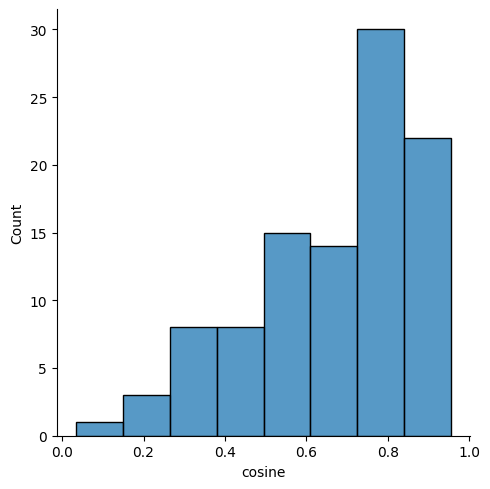

In [69]:
sns.displot(df_mamba_qa['cosine'])

# mamba with top 3 relevant document  

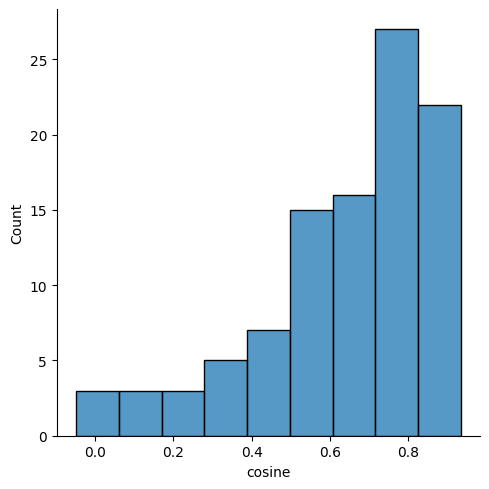

### sjrhuschlee/flan-t5-large-squad2

In [70]:
answers_trans = {}
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers_trans:
        continue

    rag_answer_llm = rag(rec,model_type="transformer")
    doc_id = rec['doc_id']
    original_doc = doc_idx[doc_id]
    law_content = original_doc['content']
    

    answers_trans[i] = {
        'law_content': law_content,
        'generated_question': rec['generated_question'],
        'rag_answer_llm': rag_answer_llm,
        'generated_answer': rec['generated_answer'],

    }

  0%|          | 0/101 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1235 > 512). Running this sequence through the model will result in indexing errors


In [71]:
df_trans = pd.DataFrame(answers_trans.values())
# df.to_csv("DeepMount00_mamba_790_hf_qa_1_top_search.csv", index=False)
df_trans.to_csv("flan-t5-large-squad2.csv", index=False)

In [72]:
results_transformer_qa = [None] * len(ground_truth)

for i, val in answers.items():
    results_transformer_qa[i] = val.copy()
    results_transformer_qa[i].update(ground_truth[i])

In [73]:
df_transformer_qa = pd.read_csv("./flan-t5-large-squad2.csv")
df_transformer_qa

,law_content,generated_question,rag_answer_llm,generated_answer
0,"Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nh...",Các loại hình cơ sở giáo dục mầm non được quy ...,<CLS>,"Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nh..."
1,1. Việc ly hôn giữa công dân Việt Nam với ngườ...,Nếu tôi là công dân Việt Nam kết hôn với người...,tại cơ quan có thẩm quyền của Việt Nam,Việc ly hôn giữa công dân Việt Nam với người n...
2,"1. Cô, dì, chú, cậu, bác ruột không sống chung...","Khi nào cô, dì, chú, cậu, bác ruột có nghĩa vụ...",Trong trường hợp một đứa cháu nhỏ hoặc trẻ vị ...,"Cô, dì, chú, cậu, bác ruột không sống chung vớ..."
3,1. Người tham gia giao thông phải chấp hành hi...,Tại nơi có cả biển báo hiệu cố định và báo hiệ...,"Ở nơi bảng hiệu cố định có tín hiệu tạm thời, ...",Tại nơi có biển báo hiệu cố định lại có báo hi...
4,1. Xe xin vượt phải có báo hiệu bằng đèn hoặc ...,Khi nào tôi được phép vượt xe bên phải thay vì...,<CLS>,Bạn được phép vượt xe bên phải trong các trườn...
...,...,...,...,...
96,Luật này quy định chế độ hôn nhân và gia đình;...,Luật Hôn Nhân Và Gia Đình điều chỉnh những vấn...,"Tự nguyện, hôn nhân tiến bộ, một người chồng v...",Luật này quy định chế độ hôn nhân và gia đình;...
97,1. Việc mang thai hộ vì mục đích nhân đạo phải...,Điều kiện để một cặp vợ chồng được nhờ người m...,a) Được chứng nhận bởi tổ chức y tế có thẩm qu...,Vợ chồng có quyền nhờ người mang thai hộ khi c...
98,1. Cha mẹ là người đại diện theo pháp luật của...,Cha mẹ có quyền tự mình thực hiện giao dịch tà...,Cha mẹ có quyền thực hiện các giao dịch của ri...,Cha hoặc mẹ có quyền tự mình thực hiện giao dị...
99,"Vợ, chồng có nghĩa vụ tôn trọng quyền tự do tí...",Vợ chồng có nghĩa vụ gì đối với quyền tự do tí...,<CLS>,"Vợ, chồng có nghĩa vụ tôn trọng quyền tự do tí..."


In [74]:
results_transformer_qa = df_transformer_qa.to_dict(orient='records')

In [81]:
similarity_transformer = []

for record in tqdm(results_transformer_qa):
    sim = compute_similarity(record)
    similarity_transformer.append(sim)

  0%|          | 0/101 [00:00<?, ?it/s]

In [82]:
df_transformer_qa['cosine'] = similarity_transformer
df_transformer_qa['cosine'].describe()

count    101.000000
mean       0.407877
std        0.341616
min       -0.238415
25%        0.089735
50%        0.469433
75%        0.697230
max        0.970881
Name: cosine, dtype: float64

In [83]:
df_mamba_qa['cosine'].describe()

count    101.000000
mean       0.667071
std        0.206907
min        0.033297
25%        0.528678
50%        0.735012
75%        0.823105
max        0.956557
Name: cosine, dtype: float64

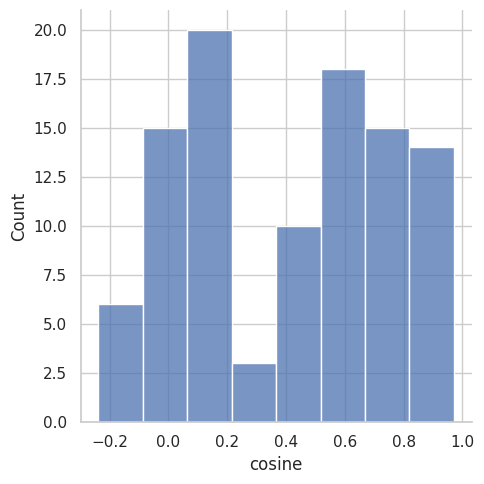

In [84]:
sns.displot(df_transformer_qa['cosine'])

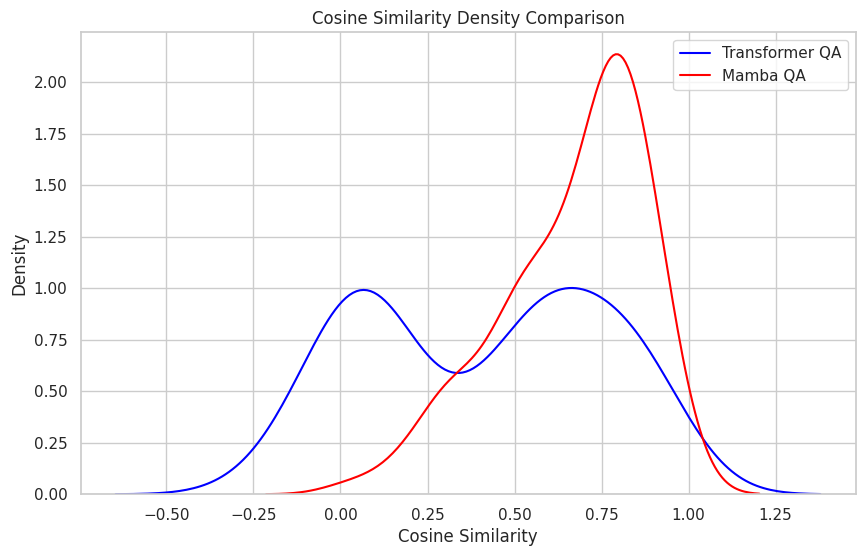

In [85]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_transformer_qa['cosine'], color='blue', label='Transformer QA')
sns.kdeplot(data=df_mamba_qa['cosine'], color='red', label='Mamba QA')

plt.title('Cosine Similarity Density Comparison')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.legend()
plt.show()

## Saving all the data